In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, bernoulli
from scipy.stats import norm

In [2]:
df = pd.read_csv('tesla_data.csv')
df

,Year,Quarter,Total Production,Total Deliveries,Delivery-Production Ratio
0,2019,2,"87,048","95,200",1.093649
1,2019,3,"96,155","97,000",1.008788
2,2019,4,"104,891","112,000",1.067775
3,2020,1,"102,672","88,496",0.861929
4,2020,2,"82,272","90,891",1.104762
5,2020,3,"145,036","139,593",0.962471
6,2020,4,"179,757","180,667",1.005062
7,2021,1,"180,338","184,877",1.025169
8,2021,2,"206,421","201,304",0.975211
9,2021,3,"237,823","241,391",1.015003


In [3]:
# Clean the data
df_clean = df.copy()
df_clean['Quarter'] = df['Quarter'].astype(int)
df_clean['Total Production'] = df_clean['Total Production'].str.replace(',', '').astype(float)
df_clean = df_clean.sort_values(by=['Year', 'Quarter']).reset_index(drop=True)
df_clean['Date'] = df_clean['Year'] + (df_clean['Quarter'] - 1) * 0.25

# Compute historical growth rates
df_clean['Prev Production'] = df_clean['Total Production'].shift(1)
df_clean['Growth Rate'] = (df_clean['Total Production'] - df_clean['Prev Production']) / df_clean['Prev Production']
growth_rates = df_clean['Growth Rate'].dropna().values

# Use Q1 2025 production as the base
q1_2025_prod = df_clean[(df_clean['Year'] == 2025) & (df_clean['Quarter'] == 1)]['Total Production'].values[0]

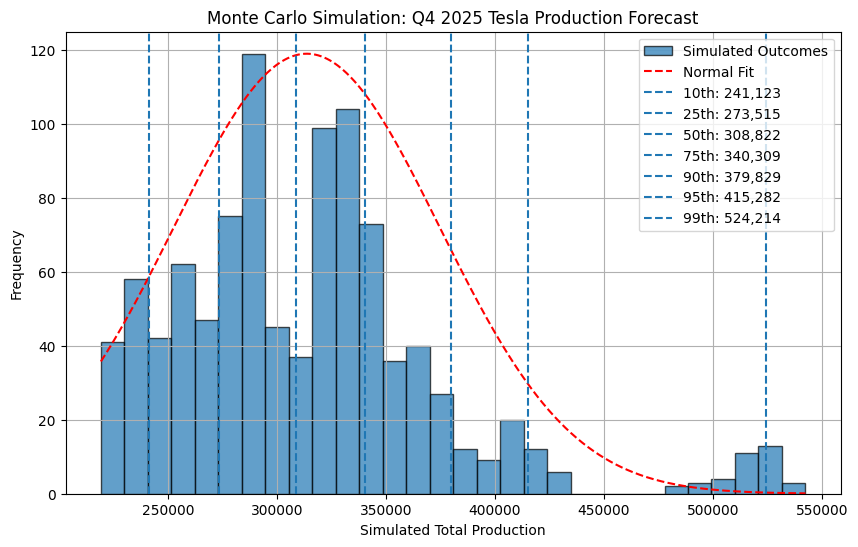

In [13]:
# Monte Carlo Simulation
np.random.seed(165)
N = 1000
sampled_growths = np.random.choice(growth_rates, size=N, replace=True)

# Factory-specific utilization using triangular distributions
shanghai = np.random.triangular(0.90, 0.96, 0.99, size=N)
fremont  = np.random.triangular(0.80, 0.86, 0.92, size=N)
berlin   = np.random.triangular(0.70, 0.85, 0.97, size=N)
texas    = np.random.triangular(0.40, 0.55, 0.70, size=N)

# Weighted average utilization based on capacity shares
total_util = (shanghai*0.95 + fremont*0.65 + berlin*0.375 + texas*0.375) / (0.95 + 0.65 + 0.375 + 0.375)
utilization = total_util

#Tesla's % of auto parts from abroad (avg 25%); auto_part_prod = np.random.uniform(0.2,0.35,size=N)
tariff_hit = np.random.uniform(0.93, 0.98, size=N) #little hit from tariff so slight decrease in numbers 

# Simulation equation
simulated_q4_2025 = q1_2025_prod * (1 + sampled_growths) * utilization * tariff_hit

# Summary stats
summary_stats = {
    'mean': np.mean(simulated_q4_2025),
    'median': np.median(simulated_q4_2025),
    'std_dev': np.std(simulated_q4_2025),
    'min': np.min(simulated_q4_2025),
    'max': np.max(simulated_q4_2025),
    '10th_percentile': np.percentile(simulated_q4_2025, 10),
    '25th_percentile': np.percentile(simulated_q4_2025, 25),
    '75th_percentile': np.percentile(simulated_q4_2025, 75),
    '90th_percentile': np.percentile(simulated_q4_2025, 90),
    '95th_percentile': np.percentile(simulated_q4_2025, 95),
    '99th_percentile': np.percentile(simulated_q4_2025, 99),
}

# Plot
plt.figure(figsize=(10, 6))
plt.hist(simulated_q4_2025, bins=30, edgecolor='black', alpha=0.7, label='Simulated Outcomes')
mu = summary_stats['mean']
std = summary_stats['std_dev']
x = np.linspace(min(simulated_q4_2025), max(simulated_q4_2025), 500)
pdf = norm.pdf(x, mu, std)
hist_vals, _ = np.histogram(simulated_q4_2025, bins=30)
scale = max(hist_vals) / max(pdf)
plt.plot(x, pdf * scale, 'r--', label='Normal Fit')

for p in [10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(simulated_q4_2025, p)
    plt.axvline(val, linestyle='--', label=f'{p}th: {int(val):,}')

plt.title("Monte Carlo Simulation: Q4 2025 Tesla Production Forecast")
plt.xlabel("Simulated Total Production")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()